<a href="https://colab.research.google.com/github/AlvaroUriel/idal_ia3/blob/main/04_CON_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Transfer Learning**

https://keras.io/applications/

Redes preentrenadas que se pueden descargar directamente en Keras:

* Xception
* VGG16
* VGG19
* ResNet
* ResNetV2
* InceptionV3
* InceptionResNetV2
* MobileNet
* MobileNetV2
* DenseNet
* NASNet
* Etc.

Algunas requieren un tamaño de imagen de entrada fijo, otras no.

In [ ]:
COLAB = True

In [ ]:
if COLAB:
    %tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# En parte de:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

Using TensorFlow backend.


In [ ]:
!ls

sample_data


In [ ]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1e79ErGKTn9ufDriDuToR5EVxfL9T3DRe',
                                        dest_path='./small_data.zip', unzip=True)

Unzipping...Done.


In [ ]:
!ls

__MACOSX  sample_data  small_data  small_data.zip


In [ ]:
!ls small_data

test0  train  validation


In [ ]:
!ls small_data/train

cats  dogs


In [ ]:
!ls small_data/train/cats

cat.0.jpg    cat.250.jpg  cat.400.jpg  cat.551.jpg  cat.701.jpg  cat.852.jpg
cat.100.jpg  cat.251.jpg  cat.401.jpg  cat.552.jpg  cat.702.jpg  cat.853.jpg
cat.101.jpg  cat.252.jpg  cat.402.jpg  cat.553.jpg  cat.703.jpg  cat.854.jpg
cat.102.jpg  cat.253.jpg  cat.403.jpg  cat.554.jpg  cat.704.jpg  cat.855.jpg
cat.103.jpg  cat.254.jpg  cat.404.jpg  cat.555.jpg  cat.705.jpg  cat.856.jpg
cat.104.jpg  cat.255.jpg  cat.405.jpg  cat.556.jpg  cat.706.jpg  cat.857.jpg
cat.105.jpg  cat.256.jpg  cat.406.jpg  cat.557.jpg  cat.707.jpg  cat.858.jpg
cat.106.jpg  cat.257.jpg  cat.407.jpg  cat.558.jpg  cat.708.jpg  cat.859.jpg
cat.107.jpg  cat.258.jpg  cat.408.jpg  cat.559.jpg  cat.709.jpg  cat.85.jpg
cat.108.jpg  cat.259.jpg  cat.409.jpg  cat.55.jpg   cat.70.jpg	 cat.860.jpg
cat.109.jpg  cat.25.jpg   cat.40.jpg   cat.560.jpg  cat.710.jpg  cat.861.jpg
cat.10.jpg   cat.260.jpg  cat.410.jpg  cat.561.jpg  cat.711.jpg  cat.862.jpg
cat.110.jpg  cat.261.jpg  cat.411.jpg  cat.562.jpg  cat.712.jpg  cat.863.jpg
c

In [ ]:
ficheros = glob("./small_data/train/cats/*")
ficheros[0]

'./small_data/train/cats/cat.807.jpg'

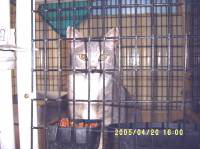

In [ ]:
imagen = load_img(ficheros[7])
imagen

In [ ]:
np.array(imagen).min(), np.array(imagen).max()

(22, 255)

In [ ]:
train_data_dir = 'small_data/train'
validation_data_dir = 'small_data/validation'
test_data_dir = 'small_data/test0'

batch_size = 16

Para ver opciones:

https://keras.io/api/preprocessing/image/#imagedatagenerator-class


In [ ]:

# data augmentation:

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    #fill_mode="constant",
    #fill_mode="reflect",
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

In [ ]:
imagen_num = np.array([img_to_array(imagen)])

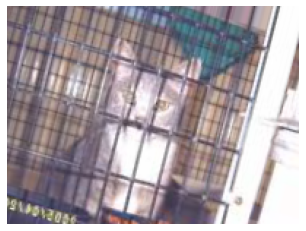

In [ ]:
plt.imshow(train_datagen.flow(imagen_num)[0][0])
plt.axis("off");

## **Red base**

https://keras.io/api/applications/

http://josephpcohen.com/w/visualizing-cnn-architectures-side-by-side-with-mxnet/

In [ ]:
# dimensiones a las que vamos a llevar las imágenes
img_width, img_height = 224, 224

normed_dims = (img_height, img_width)

In [ ]:
normed_dims

(224, 224)

In [ ]:
#from keras.applications.inception_v3 import InceptionV3
#base_model = InceptionV3(
#    weights='imagenet',
    #weights=None, # descarga arquitectura pero inicializa los pesos aleatoriamente
#    include_top=False, # no descarga las últimas capas (las de clasificación)
#    input_shape=(224,224,3))
#preprocess_input = lambda x:x/255. # una "lambda function"

In [ ]:
normed_dims + (3,)

(224, 224, 3)

In [ ]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50
base_model = ResNet50(include_top=False, input_shape=normed_dims + (3,))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/tensorflow-1.15.2/python3.7/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

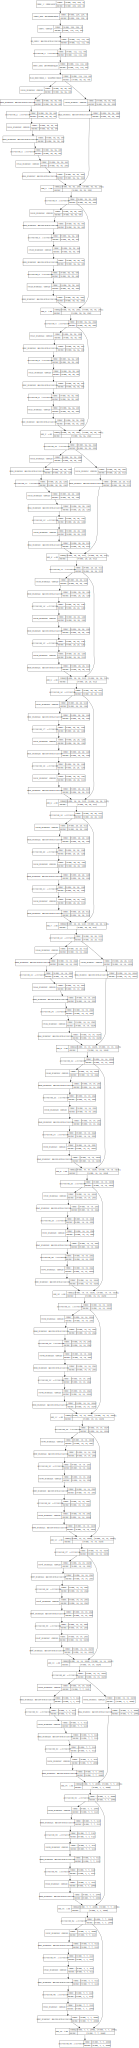

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

if COLAB:
    display(SVG(model_to_dot(base_model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(base_model, show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
7*7*2048

100352

In [ ]:
for layer in base_model.layers:
    layer.trainable = False # Transfer learning "duro"
    #layer.trainable = True # Retuning de la red descargada (si weights="imagenet")
    #layer.trainable = True # Entrenamiento de 0 de la red descargada (si weights=None)

In [ ]:
len(base_model.layers)

175

In [ ]:
#base_model.summary()

In [ ]:
# capas que añado:

aux1 = base_model.output
#aux2 = GlobalAveragePooling2D()(aux1)
aux2 = Flatten(input_shape = (2048,))(aux1)
#aux = Dropout(0.7)(aux1) # contra sobreajuste
aux3 = Dense(16, activation='relu',
             #kernel_regularizer=regularizers.l2(0.01) # 0.1, 0.01, 0.001 # contra sobreajuste
             )(aux2)
aux4 = Dense(1, activation="sigmoid")(aux3)
model = Model(input=base_model.input, output=aux4)

model.compile(optimizer='rmsprop', loss='binary_crossentropy',
              metrics=["acc"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

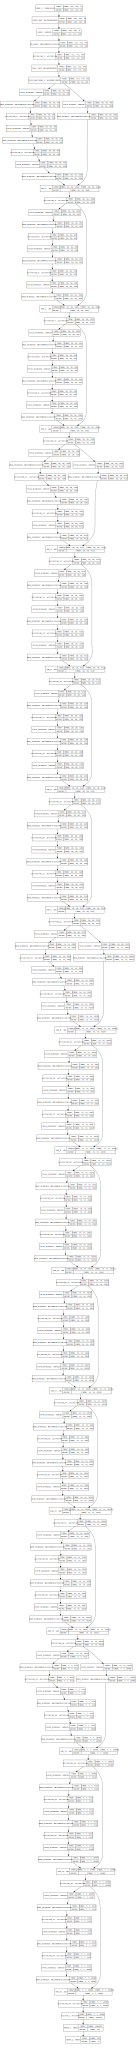

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    #rescale=1. / 255,
    preprocessing_function = preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  #rescale=1. / 255,
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  #rescale=1. / 255,
                                  preprocessing_function = preprocess_input)

In [ ]:
validation_data_dir, normed_dims

('small_data/validation', (224, 224))

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 802 images belonging to 2 classes.
Found 2002 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [ ]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n
number_test_samples  = test_generator.n

number_train_samples, number_val_samples, number_test_samples

(2000, 802, 2002)

In [ ]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

In [ ]:
epochs = 50

modelpath="model_current_best_parte3.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_acc', verbose=1,
                              save_best_only=True,
                              mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch=number_train_samples // batch_size,
                                  epochs=1,
                                  callbacks=callbacks_list,
                                  verbose=1,
                                  shuffle = True,
                                  validation_data=validation_generator,
                                  validation_steps=number_val_samples // batch_size
                                  )
    
    if history.history['val_acc'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_acc'])
        print("saving weights")
        best_val_acc = history.history['val_acc'][-1]
        #model.save(modelpath)
    
    acum_tr_acc.append(history.history['acc'][0])
    acum_val_acc.append(history.history['val_acc'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)


Epoch 1/1
125/125 [==============================] - 45s 361ms/step - loss: 0.8964 - acc: 0.8055 - val_loss: 0.0473 - val_acc: 0.9600

Epoch 00001: val_acc improved from -inf to 0.96000, saving model to model_current_best_parte3.h5
Validation accuracy improved from -1000 to [0.9599999785423279]
saving weights
Epoch 1/1
  9/125 [=>............................] - ETA: 37s - loss: 0.1693 - acc: 0.9167

KeyboardInterrupt: ignored

In [ ]:
model = load_model(modelpath)

AttributeError: ignored

## **Resultados obtenidos**

In [ ]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

125/125 [==============================] - 34s 271ms/step
Train loss    : 0.2506207227706909
Train accuracy: 0.9300000071525574

51/51 [==============================] - 8s 154ms/step
Val loss    : 0.6913642287254333
Val accuracy: 0.9650872945785522

126/126 [==============================] - 18s 145ms/step
Test loss     : 2.2845602870802395e-05
Test accuracy : 0.9685314893722534


In [ ]:
y_real = test_generator.classes
y_pred_proba = model.predict_generator(test_generator)
y_pred = np.round(y_pred_proba)
print('')
print(classification_report(y_real, y_pred))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1002
           1       1.00      0.94      0.97      1000

    accuracy                           0.97      2002
   macro avg       0.97      0.97      0.97      2002
weighted avg       0.97      0.97      0.97      2002



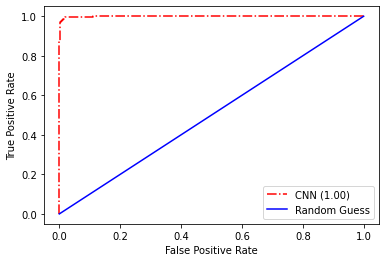

In [ ]:
fpr, tpr, thresholds = roc_curve(y_real, y_pred_proba)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()

## **Visualización de ejemplos de test**

In [ ]:
test_datagen2 = ImageDataGenerator(dtype='float32')

test_generator2 = test_datagen2.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=test_generator.n,
    shuffle=False,
    class_mode='binary')

Found 2002 images belonging to 2 classes.


In [ ]:
test_generator2.reset()
X_te, y_te = test_generator2.next()

In [ ]:
test_generator2.class_indices

{'cats': 0, 'dogs': 1}

Probabilidad perro: 1.7e+01%


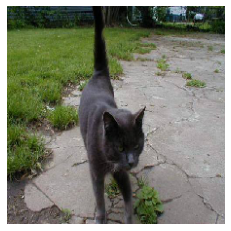

In [ ]:
ind_te1 = 14

image = X_te[ind_te1].copy()

plt.imshow(image/255, cmap='jet')
plt.axis("off")
p = model.predict(preprocess_input(np.array([image])))[0,0]
print("Probabilidad perro: {:2.2}%".format(100*p))

In [ ]:
#keras vis